# Spectral Validation of microSWIFTs with 4.5 m AWAC

In [43]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Validation Subset of Data
Times when microSWIFTs are in locations where the bottom elevation is 
between 4-5 meters for 10 consecutive minutes. This subset was first
found in the 4p5meterAWACSubset.ipynb notebook.

The subset of data consists of the following:

mission 7 - microSWIFTs 41, 37, 57, and 46

mission 18 - microSWIFTs 13, 23, 12, 4, and 5

mission 19 - microSWIFT 23

mission 26 - microSWIFT 37

mission 28 - microSWIFT 56

mission 59 - microSWIFTs 23 and 20

mission 60 - microSWIFT 71

In [12]:
mission_nc_path = '../microSWIFT_data/final_dataset/mission_18.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: DUNEX microSWIFT drifter - Mission 18
    summary: University of Washington - Applied Physics Lab team collected these data using microSWIFT wave buoys at the USACE Field Research Facility as part of the USCRP funded project DUNEX (During Nearshore Events Experiment). The file contains both directly measured and computed quantities from the drifting wave buoys. The collection and processing of these data is explained in the github repository at https://github.com/SASlabgroup/DUNEXMainExp along with examples of how these data can be used.
    institution: University of Washington - Applied Physics Lab
    source: Observations from microSWIFT drifters deployed in the DUring Nearshore Events eXperiment (DUNEX)
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    creator_country: USA
    creator_email: erainvil@uw.edu
    creator_name: EJ Rainville, Jim T

<AxesSubplot: xlabel='Cross Shore Location [meters]', ylabel='Along Shore Location [meters]'>

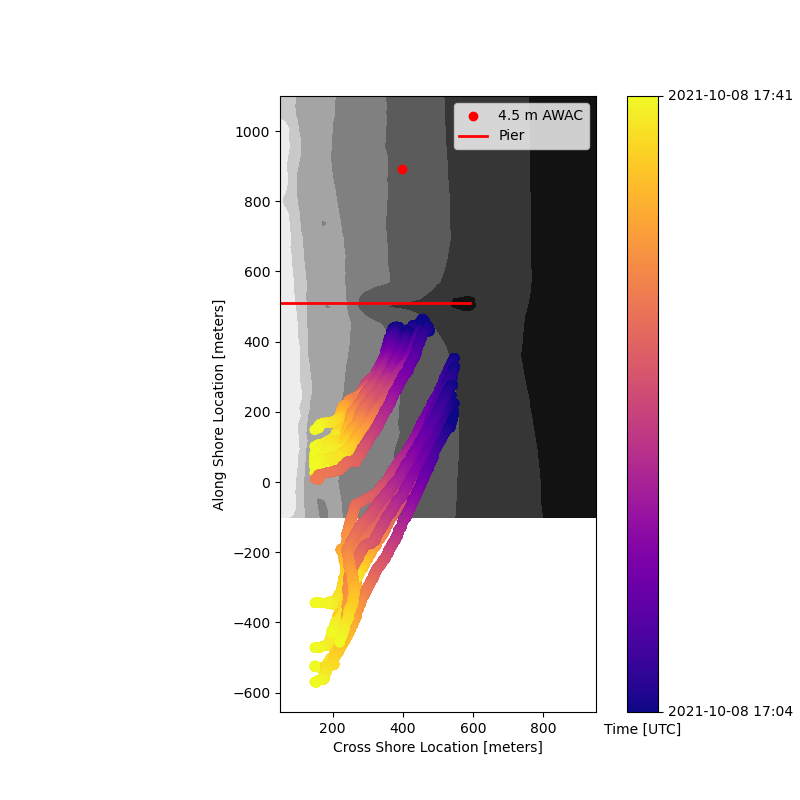

In [13]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
mission_tools.plot_mission_tracks(mission_dataset, bathy_file)

# Find the trajectories of the validation microSWIFTs

[40 13 14 22 24 23 12  4 39 38 17 19 21 20 18 11 29 56 57]


<AxesSubplot: xlabel='Cross Shore Location [meters]', ylabel='Along Shore Location [meters]'>

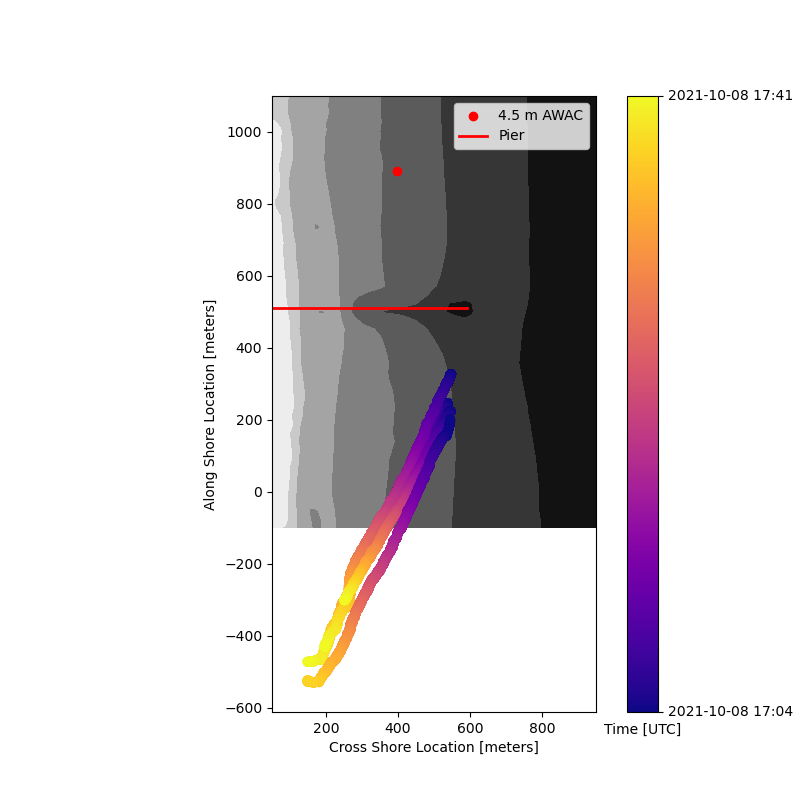

In [27]:
print(mission_dataset['trajectory'][:])
validation_trajectories = [1, 5, 6, 7] # indices of microSWIFTs 13, 23, 12, and 4
microSWIFT_nums = mission_dataset['trajectory'][validation_trajectories]
mission_tools.plot_mission_tracks(mission_dataset, bathy_file, validation_trajectories)

In [61]:
colors = ['c', 'm', 'b', 'y']
print(microSWIFT_nums)

[13 23 12  4]


# Compute bathymetry along each track and find times when the microSWIFTs are between 4 and 5 meters 

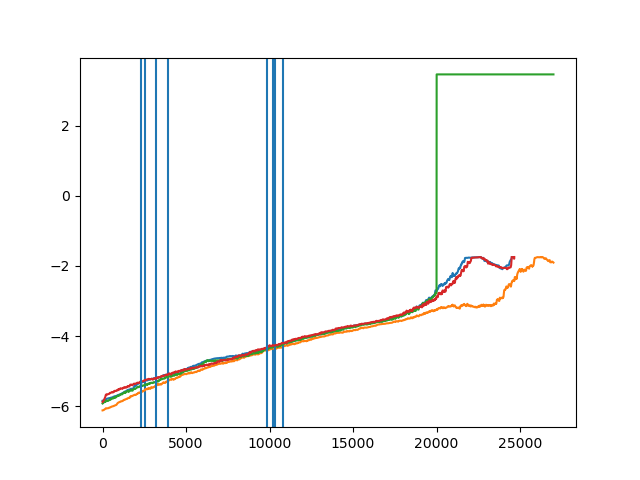

In [62]:
bathy_along_tracks = mission_tools.bathy_along_track(bathy_file,
                            mission_dataset['xFRF'][validation_trajectories,:],
                            mission_dataset['yFRF'][validation_trajectories,:])
depth_min = -5.3
depth_max = -4.3
in_depth_indices = mission_tools.ind_in_depth(bathy_along_tracks,
                                              depth_min,
                                              depth_max)

fig, ax = plt.subplots()
for n in np.arange(bathy_along_tracks.shape[0]):
    ax.plot(bathy_along_tracks[n,:])
    ax.axvline(in_depth_indices[n][0])
    ax.axvline(in_depth_indices[n][-1])
    

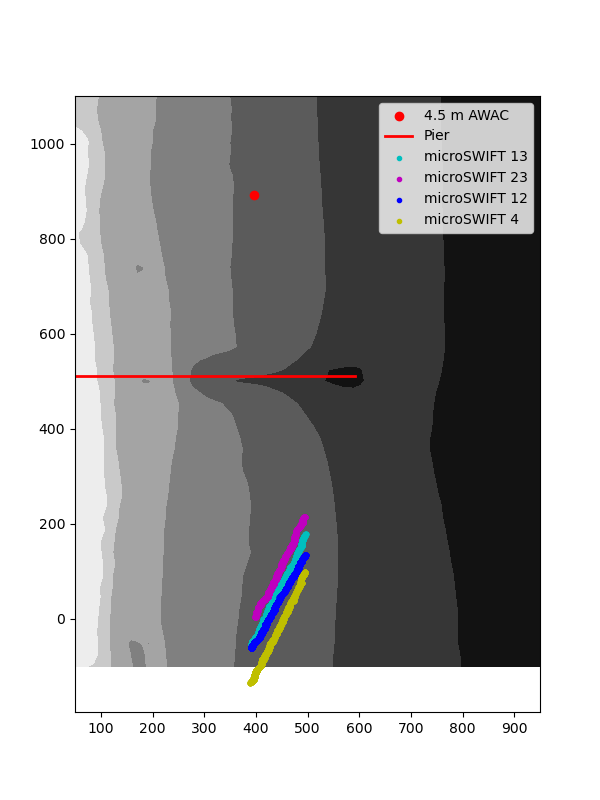

In [63]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

fig, ax = plt.subplots(figsize=(6,8))

ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')
bathy_dataset.close()

awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                        # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
            color='r', label='4.5 m AWAC')

ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier')

for n in range(len(validation_trajectories)):
    im = ax.scatter(mission_dataset['xFRF'][validation_trajectories[n], in_depth_indices[n]], 
                    mission_dataset['yFRF'][validation_trajectories[n], in_depth_indices[n]],
                    marker='.', alpha=1, color=colors[n],
                    label=f'microSWIFT {microSWIFT_nums[n]}')
ax.legend()

## Compute Spectra from each time series and Compare to the Closest AWAC Spectrum

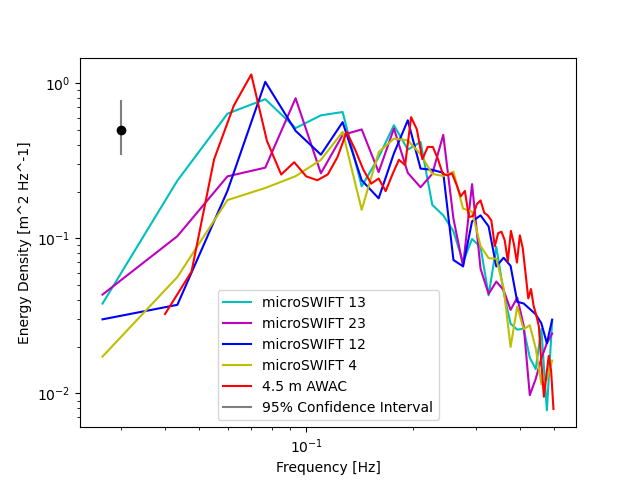

In [64]:
f_validation = []
E_validation = []
dof_validation = []
for n in range(len(validation_trajectories)):
    validation_time_series =  mission_dataset['sea_surface_elevation'][validation_trajectories[n], in_depth_indices[n]]
    f, E, dof = mission_tools.compute_spectra(validation_time_series, fs=12) 
    f_validation.append(f)
    E_validation.append(E)
    dof_validation.append(dof)

# location of confidence limit bar
conf_x = 0.03
conf_y0 = 0.5
dof = np.min(dof_validation) # lowest degrees of freedom shown the 
                             # widest confidence interval
conf = conf_y0 * dof / stats.chi2.ppf([0.025, 0.975], dof).reshape((2,1))

mission_time = np.median(mission_dataset['time'][:])
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
awac_spectra, \
awac_freq = mission_tools.closest_awac_spectra(mission_time, awac_file)
fig, ax = plt.subplots()
for n in range(len(validation_trajectories)):
    ax.loglog(f_validation[n],E_validation[n], color=colors[n], alpha=1,
    label=f'microSWIFT {microSWIFT_nums[n]}')
ax.loglog(awac_freq, awac_spectra, color='r', label='4.5 m AWAC')

# Plot the largest confidence interval
ax.plot([conf_x, conf_x], conf, color='k',alpha=0.5, lw=1.5,
        label='95% Confidence Interval')
ax.scatter(conf_x, conf_y0, color='k')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2 Hz^-1]')
ax.legend()
